# Start

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelBinarizer
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, accuracy_score
import tensorflow as tf
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras import datasets, layers, models, regularizers
from tensorflow.python.keras import Sequential
from tensorflow.python.keras.layers import Activation, Dense, Dropout, Flatten
from tensorflow.python.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.python.keras.layers import Conv2D, MaxPooling2D
from tensorflow.python.keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt
%matplotlib inline
# from tensorflow.python.keras.preprocessing.text import Tokenizer

import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

# Load the data
Let's load our data and take a look at a sample image and label.

In [2]:
train_dir = 'data/chest_xray/train'
validation_dir = 'data/chest_xray/val'
test_dir = 'data/chest_xray/test'

# Train Model (CNN)

In [3]:
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [4]:
train_generator = train_datagen.flow_from_directory(train_dir, target_size=(100, 100), 
                                                    batch_size=20, class_mode='binary', color_mode='grayscale')

validation_generator = test_datagen.flow_from_directory(validation_dir,
                                                        target_size=(100, 100),
                                                        batch_size=20,
                                                        class_mode='binary',color_mode='grayscale')

test_generator = test_datagen.flow_from_directory(test_dir, 
                                                  target_size=(100, 100), 
                                                  batch_size=20, 
                                                  class_mode='binary', color_mode='grayscale')

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [5]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(100, 100, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(85, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [6]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[
        'accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')])

In [46]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [7]:
history = model.fit(train_generator, 
                    epochs=10, 
                    validation_data=validation_generator)

Train for 261 steps, validate for 1 steps
Epoch 1/10
261/261 [==============================] - 95s 364ms/step - loss: 0.2839 - accuracy: 0.9028 - precision: 0.9132 - recall: 0.9605 - val_loss: 0.8080 - val_accuracy: 0.6875 - val_precision: 0.6154 - val_recall: 1.0000
Epoch 2/10
261/261 [==============================] - 100s 382ms/step - loss: 0.1028 - accuracy: 0.9609 - precision: 0.9708 - recall: 0.9768 - val_loss: 0.2948 - val_accuracy: 0.8750 - val_precision: 0.8000 - val_recall: 1.0000
Epoch 3/10
261/261 [==============================] - 106s 407ms/step - loss: 0.0759 - accuracy: 0.9711 - precision: 0.9787 - recall: 0.9825 - val_loss: 0.7979 - val_accuracy: 0.6875 - val_precision: 0.6154 - val_recall: 1.0000
Epoch 4/10
261/261 [==============================] - 103s 394ms/step - loss: 0.0597 - accuracy: 0.9770 - precision: 0.9815 - recall: 0.9876 - val_loss: 0.2308 - val_accuracy: 0.8750 - val_precision: 0.8000 - val_recall: 1.0000
Epoch 5/10
261/261 [===========================

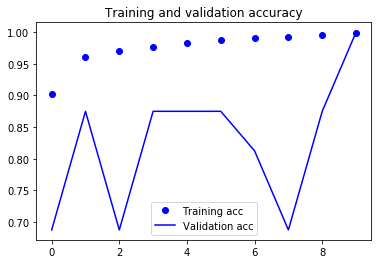

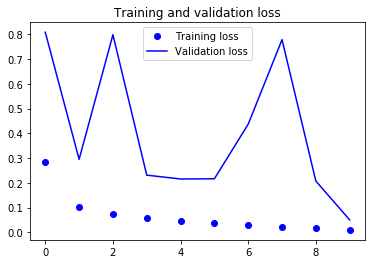

In [8]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [9]:
 model.metrics_names

['loss', 'accuracy', 'precision', 'recall']

## Evaluate FSM

In [10]:
scores = model.evaluate(test_generator)

32/32 [==============================] - 7s 203ms/step - loss: 1.2421 - accuracy: 0.7708 - precision: 0.7343 - recall: 0.9923


In [11]:
list(zip(model.metrics_names, scores))

[('loss', 1.2420807825401425),
 ('accuracy', 0.7708333),
 ('precision', 0.7343454),
 ('recall', 0.99230766)]

#### CONFUSION MATRIX

In [12]:
first_batch = test_generator.next()
data_list = first_batch[0]
batch_index = 0
class_list = first_batch[1]

while batch_index <= test_generator.batch_index:
    data = test_generator.next()
    data_list=np.concatenate((data_list, data[0]))
    class_list=np.concatenate((class_list, data[1]))
    batch_index = batch_index + 1


data_array = np.asarray(data_list)
data_array.shape

(624, 100, 100, 1)

In [13]:
# predict probabilities for test set
yhat_probs = model.predict(test_generator, verbose=1)
# predict` classes for test set
yhat_classes = model.predict_classes(data_array, verbose=0)


32/32 [==============================] - 6s 184ms/step


In [14]:
from sklearn.metrics import confusion_matrix

In [15]:
confusion_matrix(class_list, yhat_classes)

array([[ 94, 140],
       [  3, 387]])

In [16]:
import pickle

In [19]:
output_file = open("fsm_model.pickle", "wb") # "wb" means "write as bytes"
pickle.dump(history.history, output_file)
output_file.close()